In [1]:
import pandas as pd

In [2]:
import requests

In [3]:
import folium

In [4]:
from geopy.geocoders import Nominatim

In [5]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

In [7]:
CLIENT_ID='GQ45GTPM3S1KVZJEALEUKPVWNTABNR53QPICWIDDJSOV0NVC'
CLIENT_SECRET='QGQAUVUHZNSWTATCTSKS44RURCCDYSWN2VEW3UOTP1GSJSMC'
VERSION='20200605'

In [8]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [9]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [11]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [12]:
ny_data = get_new_york_data()

In [13]:
ny_data.shape

(306, 4)

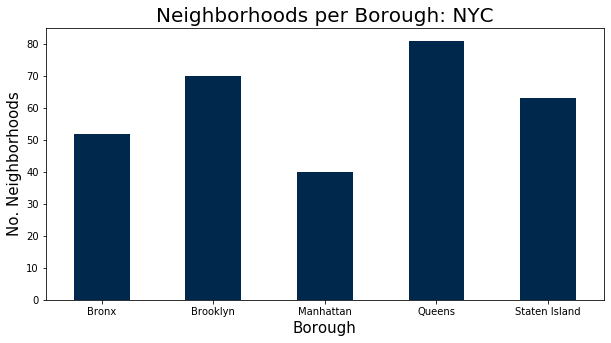

In [14]:
clr = "#00274C"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [15]:
# queens has most neighborhoods
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
soul_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    soul_resturants=venues[venues['Category']=='Southern / Soul Food Restaurant']   
    print('(',count,'/',len(ny_data),')','Southern / Soul Food Restaurant in '+Neighborhood+', '+Borough+':'+str(len(soul_resturants)))
    print(row)
    for resturant_detail in soul_resturants.values.tolist():
        id, name , category=resturant_detail
        soul_rest_ny = soul_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Southern / Soul Food Restaurant in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Southern / Soul Food Restaurant in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Southern / Soul Food Restaurant in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Southern / Soul Food Restaurant in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Southern / Soul Food Restaurant in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Southern / Soul Food Restaurant in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Southern / Soul Food Restaurant in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Southern / Soul Food Restaurant in Woodlawn, Bronx:0
['Bronx', 'Woodlawn

( 62 / 306 ) Southern / Soul Food Restaurant in Williamsburg, Brooklyn:0
['Brooklyn', 'Williamsburg', 40.70714439344251, -73.95811529220927]
( 63 / 306 ) Southern / Soul Food Restaurant in Bushwick, Brooklyn:0
['Brooklyn', 'Bushwick', 40.69811611017901, -73.92525797487045]
( 64 / 306 ) Southern / Soul Food Restaurant in Bedford Stuyvesant, Brooklyn:0
['Brooklyn', 'Bedford Stuyvesant', 40.687231607720456, -73.94178488690297]
( 65 / 306 ) Southern / Soul Food Restaurant in Brooklyn Heights, Brooklyn:0
['Brooklyn', 'Brooklyn Heights', 40.695863722724084, -73.99378225496424]
( 66 / 306 ) Southern / Soul Food Restaurant in Cobble Hill, Brooklyn:0
['Brooklyn', 'Cobble Hill', 40.687919722485574, -73.99856139218463]
( 67 / 306 ) Southern / Soul Food Restaurant in Carroll Gardens, Brooklyn:0
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Southern / Soul Food Restaurant in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
(

( 120 / 306 ) Southern / Soul Food Restaurant in Lower East Side, Manhattan:0
['Manhattan', 'Lower East Side', 40.71780674892765, -73.98089031999291]
( 121 / 306 ) Southern / Soul Food Restaurant in Tribeca, Manhattan:0
['Manhattan', 'Tribeca', 40.721521967443216, -74.01068328559087]
( 122 / 306 ) Southern / Soul Food Restaurant in Little Italy, Manhattan:0
['Manhattan', 'Little Italy', 40.71932379395907, -73.99730467208073]
( 123 / 306 ) Southern / Soul Food Restaurant in Soho, Manhattan:0
['Manhattan', 'Soho', 40.72218384131794, -74.00065666959759]
( 124 / 306 ) Southern / Soul Food Restaurant in West Village, Manhattan:0
['Manhattan', 'West Village', 40.73443393572434, -74.00617998126812]
( 125 / 306 ) Southern / Soul Food Restaurant in Manhattan Valley, Manhattan:0
['Manhattan', 'Manhattan Valley', 40.797307041702865, -73.96428617740655]
( 126 / 306 ) Southern / Soul Food Restaurant in Morningside Heights, Manhattan:0
['Manhattan', 'Morningside Heights', 40.807999738165826, -73.963

( 181 / 306 ) Southern / Soul Food Restaurant in Murray Hill, Queens:0
['Queens', 'Murray Hill', 40.764126122614066, -73.81276269135866]
( 182 / 306 ) Southern / Soul Food Restaurant in Floral Park, Queens:0
['Queens', 'Floral Park', 40.741378421945434, -73.70884705889246]
( 183 / 306 ) Southern / Soul Food Restaurant in Holliswood, Queens:0
['Queens', 'Holliswood', 40.7209572076444, -73.76714166714729]
( 184 / 306 ) Southern / Soul Food Restaurant in Jamaica Estates, Queens:0
['Queens', 'Jamaica Estates', 40.71680483014613, -73.7872269693666]
( 185 / 306 ) Southern / Soul Food Restaurant in Queensboro Hill, Queens:0
['Queens', 'Queensboro Hill', 40.7445723092867, -73.82580915110559]
( 186 / 306 ) Southern / Soul Food Restaurant in Hillcrest, Queens:0
['Queens', 'Hillcrest', 40.723824901829204, -73.79760300912672]
( 187 / 306 ) Southern / Soul Food Restaurant in Ravenswood, Queens:0
['Queens', 'Ravenswood', 40.761704526054146, -73.93157506072878]
( 188 / 306 ) Southern / Soul Food Rest

( 238 / 306 ) Southern / Soul Food Restaurant in Pleasant Plains, Staten Island:0
['Staten Island', 'Pleasant Plains', 40.524699376118136, -74.21983106616777]
( 239 / 306 ) Southern / Soul Food Restaurant in Butler Manor, Staten Island:0
['Staten Island', 'Butler Manor', 40.50608165346305, -74.22950350260027]
( 240 / 306 ) Southern / Soul Food Restaurant in Charleston, Staten Island:0
['Staten Island', 'Charleston', 40.53053148283314, -74.23215775896526]
( 241 / 306 ) Southern / Soul Food Restaurant in Rossville, Staten Island:0
['Staten Island', 'Rossville', 40.54940400650072, -74.21572851113952]
( 242 / 306 ) Southern / Soul Food Restaurant in Arden Heights, Staten Island:0
['Staten Island', 'Arden Heights', 40.54928582278321, -74.18588674583893]
( 243 / 306 ) Southern / Soul Food Restaurant in Greenridge, Staten Island:0
['Staten Island', 'Greenridge', 40.555295236173194, -74.17079414786092]
( 244 / 306 ) Southern / Soul Food Restaurant in Heartland Village, Staten Island:0
['Staten

( 295 / 306 ) Southern / Soul Food Restaurant in Malba, Queens:0
['Queens', 'Malba', 40.79060155670148, -73.82667757138641]
( 296 / 306 ) Southern / Soul Food Restaurant in Highland Park, Brooklyn:0
['Brooklyn', 'Highland Park', 40.6819989345173, -73.890345709872]
( 297 / 306 ) Southern / Soul Food Restaurant in Madison, Brooklyn:0
['Brooklyn', 'Madison', 40.60937770113766, -73.94841515328893]
( 298 / 306 ) Southern / Soul Food Restaurant in Bronxdale, Bronx:0
['Bronx', 'Bronxdale', 40.85272297633017, -73.86172577555115]
( 299 / 306 ) Southern / Soul Food Restaurant in Allerton, Bronx:0
['Bronx', 'Allerton', 40.86578787802982, -73.85931863221647]
( 300 / 306 ) Southern / Soul Food Restaurant in Kingsbridge Heights, Bronx:0
['Bronx', 'Kingsbridge Heights', 40.8703923914147, -73.90152264513144]
( 301 / 306 ) Southern / Soul Food Restaurant in Erasmus, Brooklyn:0
['Brooklyn', 'Erasmus', 40.64692606658579, -73.94817709920184]
( 302 / 306 ) Southern / Soul Food Restaurant in Hudson Yards, M

In [16]:
soul_rest_ny.to_csv('soul_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [17]:
soul_rest_ny = pd.read_csv('soul_rest_ny_tocsv1.csv')
soul_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
7,7,Manhattan,Upper West Side,4edfd5865c5cced979ab7dd1,Jacob's Pickles
8,8,Queens,St. Albans,4bca6684b6c49c746a899091,Crown Fried Chicken
9,9,Queens,Rochdale,4fda87cde4b06197212f5999,Southern Flair Restaurant
10,10,Queens,Far Rockaway,4c589a2e6407d13ad335b028,Spoonfull
11,11,Queens,Jamaica Hills,4c3aaa4916cb2d7fd8b801a9,Crown Fried Chicken


In [18]:
soul_rest_ny.shape

(12, 5)

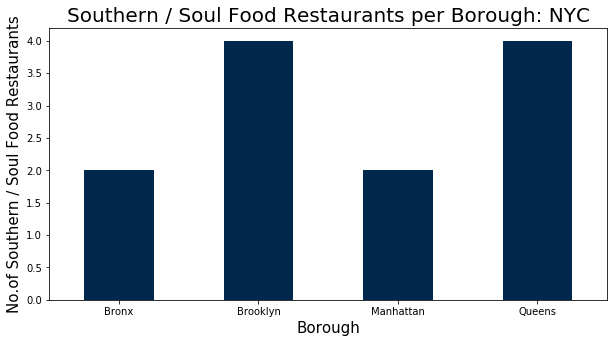

In [19]:
soul_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Southern / Soul Food Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Southern / Soul Food Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

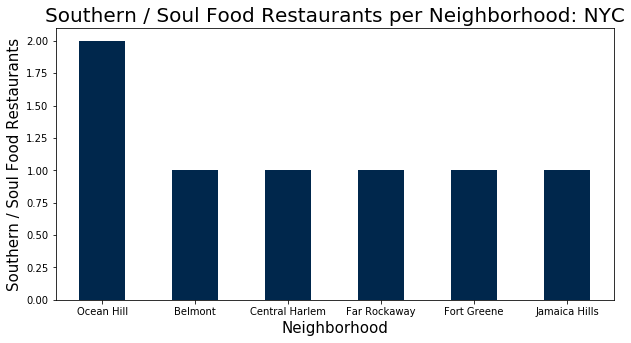

In [20]:
NOofNeigh = 6 # top number for graphing all the same past 6
soul_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Southern / Soul Food Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Southern / Soul Food Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [21]:
soul_rest_ny[soul_rest_ny['Neighborhood']=='Ocean Hill']

,Unnamed: 0,Borough,Neighborhood,ID,Name
3,3,Brooklyn,Ocean Hill,4d55d7e5ba5b224b3a5d1314,Magic Soul Food
4,4,Brooklyn,Ocean Hill,4baa3e43f964a52006573ae3,Country Kitchen Soul Food Resturant


In [26]:
soul_rest_ny2 = soul_rest_ny.drop(['Unnamed: 0'], axis=1)

In [27]:
soul_rest_ny2

,Borough,Neighborhood,ID,Name
0,Bronx,Parkchester,4c0b3abf340720a1e9eb8793,Crown Fried Chicken
1,Bronx,Belmont,4ca27b441ee76dcb950ff1dd,Bernie's Fish 'N' Chips And Restaurant
2,Brooklyn,Fort Greene,5bd49e5c1c675b002c9836ea,Peaches Hothouse
3,Brooklyn,Ocean Hill,4d55d7e5ba5b224b3a5d1314,Magic Soul Food
4,Brooklyn,Ocean Hill,4baa3e43f964a52006573ae3,Country Kitchen Soul Food Resturant
5,Brooklyn,Prospect Park South,4c1fe97deac020a125d14bc2,Manna's Soul Food
6,Manhattan,Central Harlem,4ad22304f964a5209bdf20e3,Londel's Restaurant
7,Manhattan,Upper West Side,4edfd5865c5cced979ab7dd1,Jacob's Pickles
8,Queens,St. Albans,4bca6684b6c49c746a899091,Crown Fried Chicken
9,Queens,Rochdale,4fda87cde4b06197212f5999,Southern Flair Restaurant


In [28]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
soul_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in soul_rest_ny2.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(soul_rest_ny2),')','processed')
    soul_rest_stats_ny = soul_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
soul_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5eda66479388d7001b687b68'}, 'response': {'venue': {'id': '4c0b3abf340720a1e9eb8793', 'name': 'Crown Fried Chicken', 'contact': {'phone': '7188921767', 'formattedPhone': '(718) 892-1767'}, 'location': {'address': '1459 Unionport Rd', 'crossStreet': 'at McGraw Ave', 'lat': 40.835419, 'lng': -73.855777, 'labeledLatLngs': [{'label': 'display', 'lat': 40.835419, 'lng': -73.855777}, {'label': 'entrance', 'lat': 40.835507, 'lng': -73.855628}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1459 Unionport Rd (at McGraw Ave)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crown-fried-chicken/4c0b3abf340720a1e9eb8793', 'categories': [{'id': '4bf58dd8d48988d14f941735', 'name': 'Southern / Soul Food Restaurant', 'pluralName': 'Southern / Soul Food Restaurants', 'shortName': 'Southern / Soul', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/sou

0  5bd49e5c1c675b002c9836ea  Peaches Hothouse     45     8.2    15
( 3 / 12 ) processed
{'meta': {'code': 200, 'requestId': '5eda6562006dce001b223026'}, 'response': {'venue': {'id': '4d55d7e5ba5b224b3a5d1314', 'name': 'Magic Soul Food', 'contact': {'phone': '3474259010', 'formattedPhone': '(347) 425-9010'}, 'location': {'address': '2258 Atlantic Ave', 'lat': 40.67634181055042, 'lng': -73.91060996039096, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67634181055042, 'lng': -73.91060996039096}, {'label': 'entrance', 'lat': 40.676163, 'lng': -73.910663}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2258 Atlantic Ave', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/magic-soul-food/4d55d7e5ba5b224b3a5d1314', 'categories': [{'id': '4bf58dd8d48988d14f941735', 'name': 'Southern / Soul Food Restaurant', 'pluralName': 'Southern / Soul Food Restaurants', 'shortName': 'Southern / Soul

{'meta': {'code': 200, 'requestId': '5eda66891e152c001b6d2232'}, 'response': {'venue': {'id': '4baa3e43f964a52006573ae3', 'name': 'Country Kitchen Soul Food Resturant', 'contact': {'phone': '7184980700', 'formattedPhone': '(718) 498-0700'}, 'location': {'address': '1991 Atlantic Ave', 'crossStreet': 'Saratoga St.', 'lat': 40.67667744765091, 'lng': -73.91658393184603, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67667744765091, 'lng': -73.91658393184603}, {'label': 'entrance', 'lat': 40.676826, 'lng': -73.916749}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1991 Atlantic Ave (Saratoga St.)', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/country-kitchen-soul-food-resturant/4baa3e43f964a52006573ae3', 'categories': [{'id': '4bf58dd8d48988d14f941735', 'name': 'Southern / Soul Food Restaurant', 'pluralName': 'Southern / Soul Food Restaurants', 'shortName': 'Southern / Soul',

{'meta': {'code': 200, 'requestId': '5eda66b0edbcad0023134977'}, 'response': {'venue': {'id': '4edfd5865c5cced979ab7dd1', 'name': "Jacob's Pickles", 'contact': {'phone': '2124705566', 'formattedPhone': '(212) 470-5566', 'facebook': '199095543511029', 'facebookUsername': 'jacobspickles', 'facebookName': "Jacob's Pickles"}, 'location': {'address': '509 Amsterdam Ave', 'crossStreet': 'btwn W 84th & W 85th St', 'lat': 40.78665323745776, 'lng': -73.9756219616424, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78665323745776, 'lng': -73.9756219616424}, {'label': 'entrance', 'lat': 40.786653, 'lng': -73.975563}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['509 Amsterdam Ave (btwn W 84th & W 85th St)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jacobs-pickles/4edfd5865c5cced979ab7dd1', 'categories': [{'id': '4bf58dd8d48988d14f941735', 'name': 'Southern / Soul Food Restaurant',

{'meta': {'code': 200, 'requestId': '5eda66cec8cff2001ba1600e'}, 'response': {'venue': {'id': '4bca6684b6c49c746a899091', 'name': 'Crown Fried Chicken', 'contact': {'phone': '7189780600', 'formattedPhone': '(718) 978-0600', 'twitter': 'crownchicken'}, 'location': {'address': '18903 Linden Blvd', 'crossStreet': 'Farmers Blvd', 'lat': 40.691949733145506, 'lng': -73.76201265873006, 'labeledLatLngs': [{'label': 'display', 'lat': 40.691949733145506, 'lng': -73.76201265873006}], 'postalCode': '11412', 'cc': 'US', 'city': 'Saint Albans', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18903 Linden Blvd (Farmers Blvd)', 'Saint Albans, NY 11412', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crown-fried-chicken/4bca6684b6c49c746a899091', 'categories': [{'id': '4bf58dd8d48988d14f941735', 'name': 'Southern / Soul Food Restaurant', 'pluralName': 'Southern / Soul Food Restaurants', 'shortName': 'Southern / Soul', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categorie

{'meta': {'code': 200, 'requestId': '5eda65e1a2e538001b4b5680'}, 'response': {'venue': {'id': '4c589a2e6407d13ad335b028', 'name': 'Spoonfull', 'contact': {'phone': '7183375500', 'formattedPhone': '(718) 337-5500'}, 'location': {'address': '18-54 Cornaga Ave', 'lat': 40.60236034709518, 'lng': -73.75075349080313, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60236034709518, 'lng': -73.75075349080313}], 'postalCode': '11691', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['18-54 Cornaga Ave', 'Far Rockaway, NY 11691', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spoonfull/4c589a2e6407d13ad335b028', 'categories': [{'id': '4bf58dd8d48988d14f941735', 'name': 'Southern / Soul Food Restaurant', 'pluralName': 'Southern / Soul Food Restaurants', 'shortName': 'Southern / Soul', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/southern_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCou

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
7,Manhattan,Upper West Side,4edfd5865c5cced979ab7dd1,Jacob's Pickles,1976,9.1,653
8,Queens,St. Albans,0,0,0,0,0
9,Queens,Rochdale,0,0,0,0,0
10,Queens,Far Rockaway,0,0,0,0,0
11,Queens,Jamaica Hills,4c3aaa4916cb2d7fd8b801a9,Crown Fried Chicken,6,5.9,7


In [29]:
soul_rest_stats_ny.to_csv('soul_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project


In [30]:
soul_rest_stats_ny.shape

(12, 7)

In [31]:
soul_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
Borough         12 non-null object
Neighborhood    12 non-null object
ID              12 non-null object
Name            12 non-null object
Likes           12 non-null object
Rating          12 non-null object
Tips            12 non-null object
dtypes: object(7)
memory usage: 800.0+ bytes


In [34]:
soul_rest_stats_ny['Likes']=soul_rest_stats_ny['Likes'].astype('float64')
soul_rest_stats_ny['Rating']=soul_rest_stats_ny['Rating'].astype('float64')
soul_rest_stats_ny['Tips']=soul_rest_stats_ny['Tips'].astype('float64')
soul_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
Borough         12 non-null object
Neighborhood    12 non-null object
ID              12 non-null object
Name            12 non-null object
Likes           12 non-null float64
Rating          12 non-null float64
Tips            12 non-null float64
dtypes: float64(3), object(4)
memory usage: 800.0+ bytes


In [35]:
soul_rest_stats_ny.describe()

,Likes,Rating,Tips
count,12.000000,12.000000,12.000000
mean,171.833333,3.683333,58.666667
std,568.337101,3.921927,187.267593
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,2.000000,2.950000,1.500000
75%,11.250000,7.125000,10.500000
max,1976.000000,9.100000,653.000000


In [36]:
# Resturant with maximum Likes
soul_rest_stats_ny.iloc[soul_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood             Upper West Side
ID              4edfd5865c5cced979ab7dd1
Name                     Jacob's Pickles
Likes                               1976
Rating                               9.1
Tips                                 653
Name: 7, dtype: object

In [37]:
# Resturant with maximum Ratings
soul_rest_stats_ny.iloc[soul_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Upper West Side
ID              4edfd5865c5cced979ab7dd1
Name                     Jacob's Pickles
Likes                               1976
Rating                               9.1
Tips                                 653
Name: 7, dtype: object

In [39]:
# Resturant with maximum Tips
soul_rest_stats_ny.iloc[soul_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood             Upper West Side
ID              4edfd5865c5cced979ab7dd1
Name                     Jacob's Pickles
Likes                               1976
Rating                               9.1
Tips                                 653
Name: 7, dtype: object

In [40]:
ny_neighborhood_stats=soul_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,Upper West Side,9.10
3,Fort Greene,8.20
1,Central Harlem,7.20
7,Prospect Park South,6.70
4,Jamaica Hills,5.90
5,Ocean Hill,3.55
0,Belmont,0.00
2,Far Rockaway,0.00
6,Parkchester,0.00
8,Rochdale,0.00


In [41]:
ny_borough_stats=soul_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.150
1,Brooklyn,5.500
3,Queens,1.475
0,Bronx,0.000


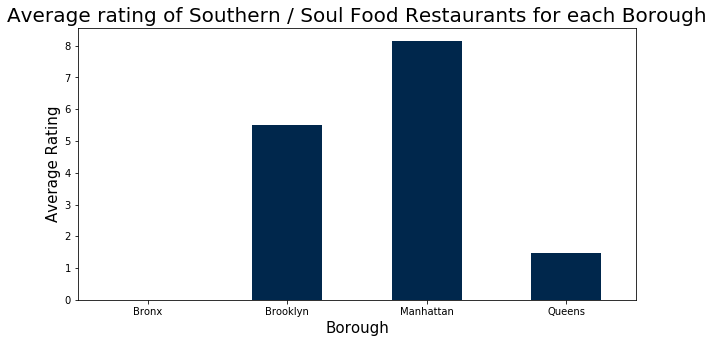

In [42]:
soul_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Southern / Soul Food Restaurants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [43]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
3,Fort Greene,8.2
10,Upper West Side,9.1


In [44]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Fort Greene,40.688527,-73.972906,8.2
1,Manhattan,Upper West Side,40.787658,-73.977059,9.1


In [45]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()
# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [75]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [74]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10.5)
ny_geo = r'Borough Boundaries.geojson'
ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_neighborhood_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.borough',
 #   threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.6, 
    line_opacity=0.2,
    legend_name='Average Rating',
    reset=True
)
# display map
# as this is huge map data , we will save it to a file
ny_map
#ny_map.save('borough_rating.html')